In [824]:
#Import libraries
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM 
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import statsmodels.api as sm
from scipy import stats

In [825]:
#load in our dataset
df = pd.read_csv("Resources/mountain_pastured_cows.csv")
display(df.head())

,newid,lact_num,calv_date,alp_date,avg_milk,avg_thi3,avg_csi3,avg_thi30,avg_csi30,avg_precspring
0,224364,5,2010-02-19,2010-06-05,26.20,60.17,966.13,54.81,1038.28,134.61
1,83453,5,2001-11-09,2002-06-15,12.20,66.08,917.76,54.56,1111.54,184.40
2,261565,3,2000-09-16,2001-06-24,14.60,66.78,899.06,61.77,1000.32,184.08
3,122783,5,2008-10-18,2009-06-29,15.17,63.49,1053.80,62.35,1037.26,116.96
4,252570,1,2007-09-14,2008-06-02,12.03,65.96,969.90,61.04,998.60,154.72


## Data Preprocessing

### Data Cleaning 

In [826]:
#check dtypes
df.dtypes

newid               int64
lact_num            int64
calv_date          object
alp_date           object
avg_milk          float64
avg_thi3          float64
avg_csi3          float64
avg_thi30         float64
avg_csi30         float64
avg_precspring    float64
dtype: object

In [827]:
#check for nulls, negligible amount, should be clear to dropna
print(df.isna().sum()/len(df))
print(df.shape)

newid             0.00000
lact_num          0.00000
calv_date         0.00000
alp_date          0.00000
avg_milk          0.00000
avg_thi3          0.00205
avg_csi3          0.00205
avg_thi30         0.00205
avg_csi30         0.00205
avg_precspring    0.00000
dtype: float64
(20000, 10)


In [828]:
df = df.dropna()
print(df.shape)

(19959, 10)


## Exploratory Data Analysis

In [829]:
df["avg_milk"].describe()

count    19959.000000
mean        15.921083
std          4.078102
min          3.500000
25%         13.070000
50%         15.600000
75%         18.500000
max         40.370000
Name: avg_milk, dtype: float64

In [830]:
# The most frequently produced milk production value (mode)
mode_milk = stats.mode(df['avg_milk'])[0]  

# Print the mode
print(f"Mode of avg_milk: {mode_milk}") 

Mode of avg_milk: 14.6


In [831]:
# For the Target column ("Y"), avg_milk production, calculate the number of cows for the min and max, 
# and calculate the cumulative number of cows at quartiles 25%, 50% and 75% (moooooooooooooooo!!!!)
min_milk_count = (df['avg_milk'] == df['avg_milk'].min()).sum()
max_milk_count = (df['avg_milk'] == df['avg_milk'].max()).sum()
p25_count = (df['avg_milk'] < df['avg_milk'].quantile(0.25)).sum()
p50_count = (df['avg_milk'] < df['avg_milk'].quantile(0.50)).sum()
p75_count = (df['avg_milk'] < df['avg_milk'].quantile(0.75)).sum()

# print the cumlative number of cows below the certain thresholds)
print(f"Number of cows with minimum milk production (3.5 kg): {min_milk_count}")
print(f"Number of cows with maximum milk production (40.37 kg): {max_milk_count}")
print(f"Number of cows that produced less than the 25th percentile (13.07 kg): {p25_count}") 
print(f"Number of cows that produced less than the median (15.60 kg): {p50_count}")
print(f"Number of cows that produced less than the 75th percentile (18.50 kg): {p75_count}")


Number of cows with minimum milk production (3.5 kg): 1
Number of cows with maximum milk production (40.37 kg): 2
Number of cows that produced less than the 25th percentile (13.07 kg): 4979
Number of cows that produced less than the median (15.60 kg): 9911
Number of cows that produced less than the 75th percentile (18.50 kg): 14965


In [832]:
# Extact from the dataset and examine the data of the cow with exceptionally low milk yield to gather some insight behind these values.

# Find the cow(s) that produced 3.5 kg of milk
cows_with_min_milk = df[df['avg_milk'] == 3.5] 
cows_with_min_milk


,newid,lact_num,calv_date,alp_date,avg_milk,avg_thi3,avg_csi3,avg_thi30,avg_csi30,avg_precspring
3844,37340,2,2001-09-29,2002-07-03,3.5,59.18,1091.85,60.98,1040.56,186.71


In [833]:
# Extact from the dataset and examine the data of the cow with exceptionally high milk yield to gather some insight behind these values.

# Find the cow(s) that produced 40.37 kg of milk:
cows_with_max_milk = df[df['avg_milk'] == 40.37] 
cows_with_max_milk

,newid,lact_num,calv_date,alp_date,avg_milk,avg_thi3,avg_csi3,avg_thi30,avg_csi30,avg_precspring
3923,176146,8,2013-09-28,2013-10-09,40.37,44.27,1088.68,46.34,1140.58,182.28
6922,376495,8,2013-09-28,2013-10-09,40.37,44.27,1088.68,46.34,1140.58,182.28


Number of cows within 1 standard deviation: 13753
Number of cows within 2 standard deviations: 19067
Number of cows within 3 standard deviations: 19865


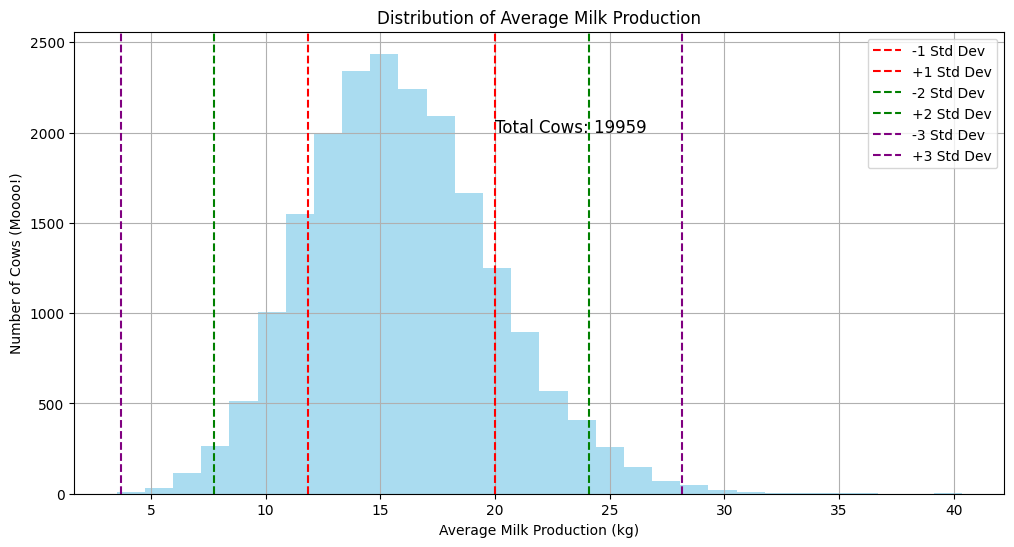

In [834]:
# For the defined target Column ("Y"), avg_milk production, 
# calculate and observe the number of cows within 1 standard deviation, 2 and 3 standard deviations and graph the results 

# Extract relevant statistics
mean = 15.921083
std_dev = 4.078102
total_cows = 19959

# Calculate standard deviation boundaries
lower_bound_1std = mean - std_dev
upper_bound_1std = mean + std_dev
lower_bound_2std = mean - 2 * std_dev
upper_bound_2std = mean + 2 * std_dev
lower_bound_3std = mean - 3 * std_dev
upper_bound_3std = mean + 3 * std_dev

# Count cows within standard deviation ranges 
num_cows_within_1std = ((df['avg_milk'] >= lower_bound_1std) & (df['avg_milk'] <= upper_bound_1std)).sum()
num_cows_within_2std = ((df['avg_milk'] >= lower_bound_2std) & (df['avg_milk'] <= upper_bound_2std)).sum()
num_cows_within_3std = ((df['avg_milk'] >= lower_bound_3std) & (df['avg_milk'] <= upper_bound_3std)).sum()

# Print the number of cows within each standard deviation range
print(f"Number of cows within 1 standard deviation: {num_cows_within_1std}")
print(f"Number of cows within 2 standard deviations: {num_cows_within_2std}")
print(f"Number of cows within 3 standard deviations: {num_cows_within_3std}")

# Create the histogram
plt.figure(figsize=(12, 6))

plt.hist(df['avg_milk'], bins=30, color='skyblue', alpha=0.7)

# Plot vertical lines for standard deviations
plt.axvline(lower_bound_1std, color='red', linestyle='--', label='-1 Std Dev')
plt.axvline(upper_bound_1std, color='red', linestyle='--', label='+1 Std Dev')
plt.axvline(lower_bound_2std, color='green', linestyle='--', label='-2 Std Dev')
plt.axvline(upper_bound_2std, color='green', linestyle='--', label='+2 Std Dev')
plt.axvline(lower_bound_3std, color='purple', linestyle='--', label='-3 Std Dev')
plt.axvline(upper_bound_3std, color='purple', linestyle='--', label='+3 Std Dev')

# Add labels and title
plt.xlabel('Average Milk Production (kg)')
plt.ylabel('Number of Cows (Moooo!)')
plt.title('Distribution of Average Milk Production')
plt.legend()

# Add gridlines
plt.grid(True)

# Add total number of cows as text
plt.text(20, 2000, f"Total Cows: {total_cows}", fontsize=12)

plt.show()

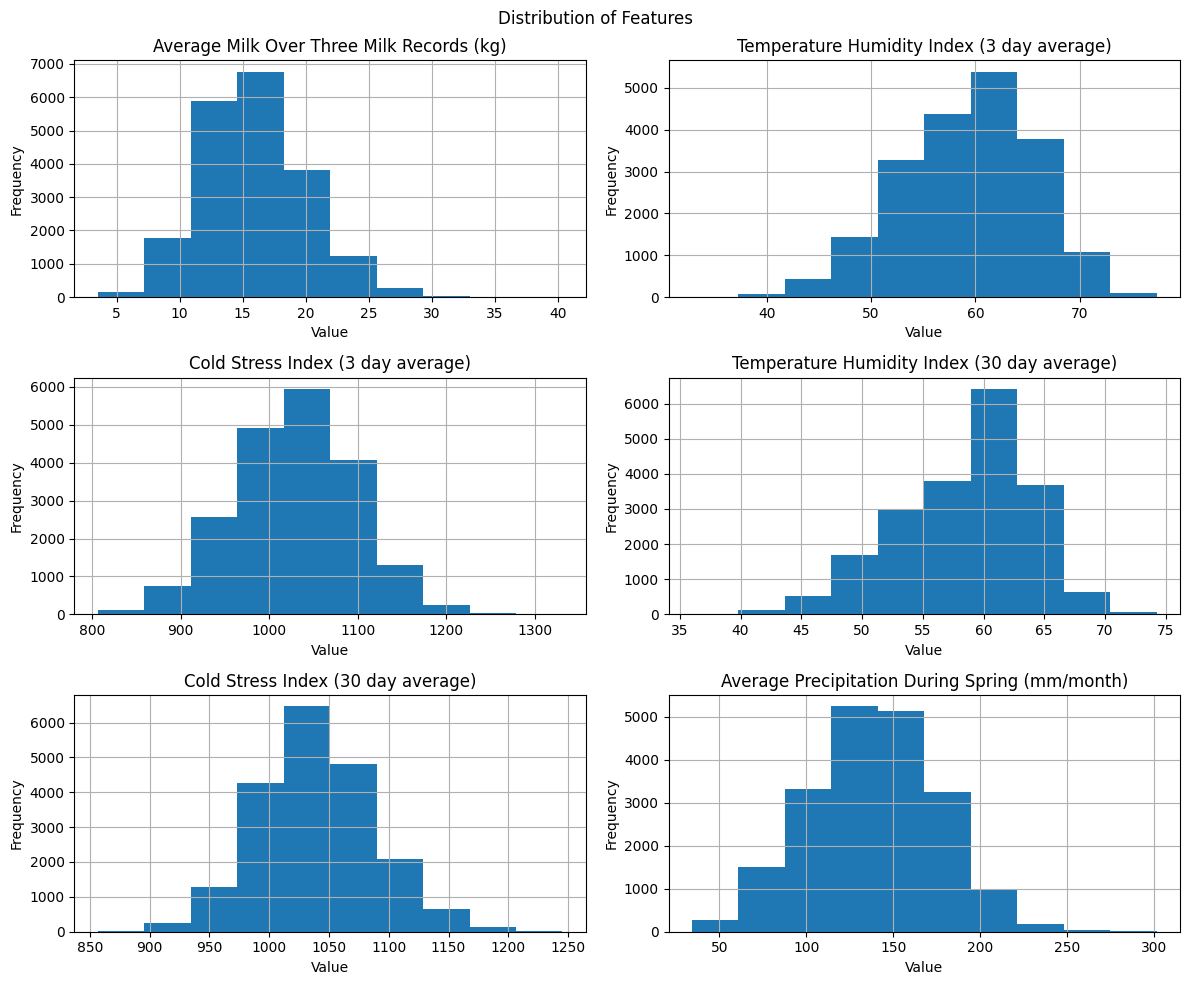

<Figure size 640x480 with 0 Axes>

In [835]:
# Visualize distributions of numeric columns
numeric_columns = ['avg_milk', 'avg_thi3', 'avg_csi3', 'avg_thi30', 'avg_csi30', 'avg_precspring']
axes = df[numeric_columns].hist(figsize=(12, 10))
plt.suptitle("Distribution of Features")
# Add Labels for each fig
titles = ['Average Milk Over Three Milk Records (kg)', 'Temperature Humidity Index (3 day average)', 'Cold Stress Index (3 day average)',
          'Temperature Humidity Index (30 day average)','Cold Stress Index (30 day average)', 'Average Precipitation During Spring (mm/month)']
xlabel = "Value"
ylabel = "Frequency"
for fig, title in zip(axes.flatten(), titles):
    fig.set_title(title)
    fig.set_xlabel(xlabel)
    fig.set_ylabel(ylabel)
# show charts
plt.tight_layout()
plt.show()
plt.savefig('Resources/milk_histogram.svg')

In [836]:
df.columns

Index(['newid', 'lact_num', 'calv_date', 'alp_date', 'avg_milk', 'avg_thi3',
       'avg_csi3', 'avg_thi30', 'avg_csi30', 'avg_precspring'],
      dtype='object')

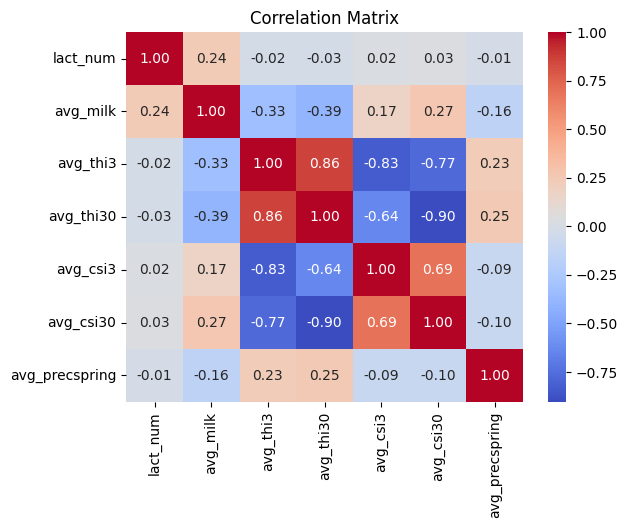

In [837]:
features = ['lact_num', 'avg_milk', 'avg_thi3', 'avg_thi30', 'avg_csi3', 'avg_csi30',
       'avg_precspring', ]


corr_matrix = df[features].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [838]:
# Calculate VIF
X = df[features]
X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [vif(X.values, i) for i in range(X.shape[1])]

print(vif_data)

          Feature          VIF
0           const  6638.855610
1        lact_num     1.072642
2        avg_milk     1.330297
3        avg_thi3    10.784076
4       avg_thi30    15.486415
5        avg_csi3     5.211069
6       avg_csi30     8.805977
7  avg_precspring     1.182452


In [839]:
# Conduct the regression analysis since there are VIF values over 10
# Define the dependent variable

y = df['avg_milk']  # Replace with your actual target variable name

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               avg_milk   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.545e+31
Date:                Tue, 28 Jan 2025   Prob (F-statistic):               0.00
Time:                        20:59:30   Log-Likelihood:             5.9532e+05
No. Observations:               19959   AIC:                        -1.191e+06
Df Residuals:                   19951   BIC:                        -1.191e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           3.522e-13   1.55e-14     22.

### Feature Engineering

In [840]:
# Convert date columns to datetime format:
df['calv_date'] = pd.to_datetime(df['calv_date'])
df['alp_date'] = pd.to_datetime(df['alp_date'])

# 	Calculate the time elapsed between calving and the first record in the alp (lactation duration). 
df['date_diff'] = (df['alp_date'] - df['calv_date']).dt.days

df.head()

,newid,lact_num,calv_date,alp_date,avg_milk,avg_thi3,avg_csi3,avg_thi30,avg_csi30,avg_precspring,date_diff
0,224364,5,2010-02-19,2010-06-05,26.20,60.17,966.13,54.81,1038.28,134.61,106
1,83453,5,2001-11-09,2002-06-15,12.20,66.08,917.76,54.56,1111.54,184.40,218
2,261565,3,2000-09-16,2001-06-24,14.60,66.78,899.06,61.77,1000.32,184.08,281
3,122783,5,2008-10-18,2009-06-29,15.17,63.49,1053.80,62.35,1037.26,116.96,254
4,252570,1,2007-09-14,2008-06-02,12.03,65.96,969.90,61.04,998.60,154.72,262


In [841]:
#Replace datetime columns with numerical

# df['calv_year'] = df['calv_date'].dt.year | causes multicollinearity issues
df['calv_month'] = df['calv_date'].dt.month
df['calv_day_of_month'] = df['calv_date'].dt.day

# df['alp_year'] = df['alp_date'].dt.year | causes multicollinearity issues
df['alp_month'] = df['alp_date'].dt.month
df['alp_day_of_month'] = df['alp_date'].dt.day

df.head()


,newid,lact_num,calv_date,alp_date,avg_milk,avg_thi3,avg_csi3,avg_thi30,avg_csi30,avg_precspring,date_diff,calv_month,calv_day_of_month,alp_month,alp_day_of_month
0,224364,5,2010-02-19,2010-06-05,26.20,60.17,966.13,54.81,1038.28,134.61,106,2,19,6,5
1,83453,5,2001-11-09,2002-06-15,12.20,66.08,917.76,54.56,1111.54,184.40,218,11,9,6,15
2,261565,3,2000-09-16,2001-06-24,14.60,66.78,899.06,61.77,1000.32,184.08,281,9,16,6,24
3,122783,5,2008-10-18,2009-06-29,15.17,63.49,1053.80,62.35,1037.26,116.96,254,10,18,6,29
4,252570,1,2007-09-14,2008-06-02,12.03,65.96,969.90,61.04,998.60,154.72,262,9,14,6,2


In [842]:
df.dtypes

newid                         int64
lact_num                      int64
calv_date            datetime64[ns]
alp_date             datetime64[ns]
avg_milk                    float64
avg_thi3                    float64
avg_csi3                    float64
avg_thi30                   float64
avg_csi30                   float64
avg_precspring              float64
date_diff                     int64
calv_month                    int32
calv_day_of_month             int32
alp_month                     int32
alp_day_of_month              int32
dtype: object

In [843]:
# remove problematic or no longer needed columns
df = df.drop(["newid",'avg_thi30', 'calv_date', 'alp_date'], axis = 1)
df.head()

,lact_num,avg_milk,avg_thi3,avg_csi3,avg_csi30,avg_precspring,date_diff,calv_month,calv_day_of_month,alp_month,alp_day_of_month
0,5,26.20,60.17,966.13,1038.28,134.61,106,2,19,6,5
1,5,12.20,66.08,917.76,1111.54,184.40,218,11,9,6,15
2,3,14.60,66.78,899.06,1000.32,184.08,281,9,16,6,24
3,5,15.17,63.49,1053.80,1037.26,116.96,254,10,18,6,29
4,1,12.03,65.96,969.90,998.60,154.72,262,9,14,6,2


## Model Training 

In [844]:
# Split the features and target data
y = df['avg_milk']
X = df.drop('avg_milk', axis = 1)


In [845]:
# Review the features Dataframe 
display(X.head())
display(y)

,lact_num,avg_thi3,avg_csi3,avg_csi30,avg_precspring,date_diff,calv_month,calv_day_of_month,alp_month,alp_day_of_month
0,5,60.17,966.13,1038.28,134.61,106,2,19,6,5
1,5,66.08,917.76,1111.54,184.40,218,11,9,6,15
2,3,66.78,899.06,1000.32,184.08,281,9,16,6,24
3,5,63.49,1053.80,1037.26,116.96,254,10,18,6,29
4,1,65.96,969.90,998.60,154.72,262,9,14,6,2


0        26.20
1        12.20
2        14.60
3        15.17
4        12.03
         ...  
19995    19.38
19996    23.57
19997    21.23
19998    11.63
19999    10.47
Name: avg_milk, Length: 19959, dtype: float64

In [846]:
# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [847]:
# Instantiate a StandardScaler instance
scaler = StandardScaler()

# Fit the training data to the standard scaler
X_scaler = scaler.fit(X_train)

# Transform the training data using the scaler
X_train_scaled = X_scaler.transform(X_train)

# Transform the testing data using the scaler
X_test_scaled = X_scaler.transform(X_test)

display(X_train_scaled)
display(X_test_scaled)

array([[-0.85380113,  0.359709  ,  0.33647469, ..., -1.2485292 ,
        -0.04165949, -1.30245132],
       [ 1.83897407, -0.57709985,  0.18911688, ...,  0.70777361,
        -0.04165949,  1.23919181],
       [-0.31524609, -1.17899558,  0.53447751, ..., -1.36360583,
        -0.04165949,  0.08389948],
       ...,
       [-0.31524609,  0.9568654 , -1.12691528, ..., -0.44299274,
        -0.04165949, -0.72480516],
       [-0.85380113,  0.01531722, -0.00386573, ...,  1.28315679,
        -0.04165949, -0.03162976],
       [ 1.30041903, -2.05893239,  1.59123081, ...,  0.13239044,
        -0.04165949,  1.58577951]])

array([[-0.85380113, -0.04155482, -0.65752605, ...,  0.0173138 ,
        -0.04165949,  0.77707488],
       [ 0.22330895, -0.67188658,  0.25807089, ...,  0.70777361,
        -0.04165949, -1.41798055],
       [-0.31524609, -0.90569384,  1.05436411, ..., -0.90329929,
        -0.04165949,  0.43048718],
       ...,
       [ 0.22330895,  0.21120979,  0.00838948, ...,  0.59269698,
        -0.04165949, -0.26268822],
       [-0.85380113, -1.54866383,  1.95298093, ...,  1.74346334,
        -0.04165949, -0.72480516],
       [ 0.76186399,  0.7404357 , -0.36162921, ...,  0.82285025,
        -0.04165949,  0.66154564]])

## Define the Artifical Neural Network (ANN) Model

### Create and fit a feedforward ANN Model 

In [848]:
# Initialize the ANN
ann_model = Sequential()

# Input layer and first hidden layer
ann_model.add(Dense(units=10, activation='relu', input_dim=X_train_scaled.shape[1]))

# Output layer
ann_model.add(Dense(units=1, activation='linear'))  # For regression

# Compile the model
ann_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Train the model
ann_history = ann_model.fit(X_train_scaled, y_train, epochs=100, batch_size=5, validation_split=0.2)



Epoch 1/100


/Applications/anaconda3/envs/dev/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2236/2236 ━━━━━━━━━━━━━━━━━━━━ 1s 409us/step - loss: 111.5662 - mean_absolute_error: 8.9227 - val_loss: 13.8447 - val_mean_absolute_error: 2.9349
Epoch 2/100
2236/2236 ━━━━━━━━━━━━━━━━━━━━ 1s 387us/step - loss: 13.3430 - mean_absolute_error: 2.8530 - val_loss: 11.0580 - val_mean_absolute_error: 2.6185
Epoch 3/100
2236/2236 ━━━━━━━━━━━━━━━━━━━━ 1s 383us/step - loss: 11.0397 - mean_absolute_error: 2.6098 - val_loss: 10.4040 - val_mean_absolute_error: 2.5377
Epoch 4/100
2236/2236 ━━━━━━━━━━━━━━━━━━━━ 1s 388us/step - loss: 10.7577 - mean_absolute_error: 2.5612 - val_loss: 9.9888 - val_mean_absolute_error: 2.4706
Epoch 5/100
2236/2236 ━━━━━━━━━━━━━━━━━━━━ 1s 385us/step - loss: 10.6734 - mean_absolute_error: 2.5582 - val_loss: 9.7812 - val_mean_absolute_error: 2.4513
Epoch 6/100
2236/2236 ━━━━━━━━━━━━━━━━━━━━ 1s 390us/step - loss: 10.5106 - mean_absolute_error: 2.5369 - val_loss: 9.8275 - val_mean_absolute_error: 2.4611
Epoch 7/100
2236/2236 ━━━━━━━━━━━━━━━━━━━━ 1s 383us/step - loss: 10.3384

In [849]:
# Evaluate the model
ann_loss, ann_mae = ann_model.evaluate(X_test_scaled, y_test)
print(f'ANN Mean Absolute Error: {ann_mae}')

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 10.5671 - mean_absolute_error: 2.5127
ANN Mean Absolute Error: 2.4630422592163086


In [850]:
# Calculate MAE as %
# Calculate the mean of actual values
mean_actual = np.mean(y_test)

# Calculate the percentage MAE
percentage_mae = (ann_mae / mean_actual) * 100

# Print the result
print(f"Percentage MAE: {percentage_mae:.2f}%")

Percentage MAE: 15.56%


MAE as a percentage of the mean of the actual values from the test dataset. 

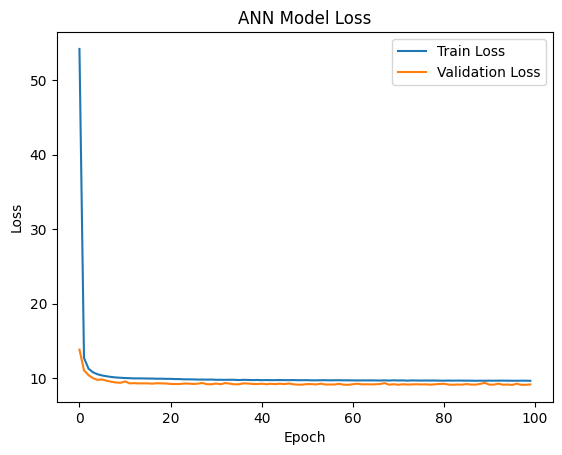

In [851]:
# Plot training and validation loss
plt.plot(ann_history.history['loss'], label='Train Loss')
plt.plot(ann_history.history['val_loss'], label='Validation Loss')
plt.title('ANN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [852]:
# Reshape the input for LSTM (samples, time steps, features)
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [853]:
# Initialize the LSTM model
lstm_model = Sequential()

In [854]:
# Add LSTM layer
lstm_model.add(LSTM(units=50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))

/Applications/anaconda3/envs/dev/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [855]:
# Output layer
lstm_model.add(Dense(units=1, activation='linear'))  # For regression

In [856]:
# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

In [857]:
# Train the model
lstm_history = lstm_model.fit(X_train_lstm, y_train, epochs=100, batch_size=5, validation_split=0.2)

Epoch 1/100
2236/2236 ━━━━━━━━━━━━━━━━━━━━ 2s 593us/step - loss: 102.5939 - mean_absolute_error: 8.0729 - val_loss: 10.4703 - val_mean_absolute_error: 2.5338
Epoch 2/100
2236/2236 ━━━━━━━━━━━━━━━━━━━━ 1s 551us/step - loss: 11.0212 - mean_absolute_error: 2.5876 - val_loss: 9.8159 - val_mean_absolute_error: 2.4298
Epoch 3/100
2236/2236 ━━━━━━━━━━━━━━━━━━━━ 1s 542us/step - loss: 10.1277 - mean_absolute_error: 2.4842 - val_loss: 9.5698 - val_mean_absolute_error: 2.3965
Epoch 4/100
2236/2236 ━━━━━━━━━━━━━━━━━━━━ 1s 540us/step - loss: 9.9951 - mean_absolute_error: 2.4622 - val_loss: 9.3974 - val_mean_absolute_error: 2.3912
Epoch 5/100
2236/2236 ━━━━━━━━━━━━━━━━━━━━ 1s 552us/step - loss: 9.8505 - mean_absolute_error: 2.4406 - val_loss: 9.2320 - val_mean_absolute_error: 2.3598
Epoch 6/100
2236/2236 ━━━━━━━━━━━━━━━━━━━━ 1s 562us/step - loss: 9.7853 - mean_absolute_error: 2.4369 - val_loss: 9.1562 - val_mean_absolute_error: 2.3477
Epoch 7/100
2236/2236 ━━━━━━━━━━━━━━━━━━━━ 1s 536us/step - loss: 

In [858]:
# Evaluate the model
lstm_loss, lstm_mae = lstm_model.evaluate(X_test_lstm, y_test)
print(f'LSTM Mean Absolute Error: {lstm_mae}')

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - loss: 10.6610 - mean_absolute_error: 2.5264
LSTM Mean Absolute Error: 2.478790044784546


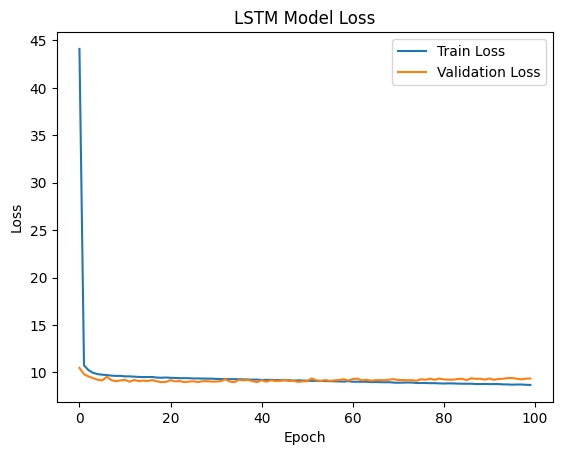

In [859]:
# Plot training and validation loss
plt.plot(lstm_history.history['loss'], label='Train Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [860]:
# Export our model and our scaler for use in out gradio notebook
from pathlib import Path
file_path = Path("milking_the_data.keras")
model.save(file_path)

import pickle
# Save the scaler to a file using pickle
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)